In [ ]:
#If the initial weights are too confident with wrong values by randomly initializing it might lead to heavy losses in first few epochs
#if the input to tanh layer isn't gaussian then it'll saturate values at its extreme ends-> can be avoided by kaiming init
#batch normalize to make it gaussian
#running mean and std to finally forward pass a single value if needed

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
vocab_size = len(itos)

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
n_embed = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)*(5/3)/((n_embed*block_size)**0.5) #kaiming init 
b1 = torch.randn(n_hidden, generator=g)*0.01 #ends of -1 to 1
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.01#The model shouldnt be confident with the initial logits
b2 = torch.randn(vocab_size, generator=g)*0#so that the loss wont be very much high

#batch normalization
bngain = torch.ones(1,n_hidden)
bnbias = torch.zeros(1,n_hidden)

bnmean_running = torch.ones(1,n_hidden)
bnstd_running = torch.zeros(1,n_hidden)

parameters = [C, W1, W2, b2, bngain, bnbias]

In [15]:
sum(p.nelement() for p in parameters) # number of parameters in total

12097

In [17]:
for p in parameters:
    p.requires_grad = True

In [18]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [19]:
lri = []
lossi = []
stepi = []
batch_size = 32

In [21]:
for i in range(200000):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    hpreact = emb.view(emb.shape[0],-1) @ W1 #+ b1 // not needed as it'll be subtracted by mean anyway-->replaced by bnmean
    meani = hpreact.mean(0, keepdim = True)
    stdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - meani) / stdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * meani
        bnstd_running = 0.999 * bnstd_running + 0.001 * stdi
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    if i%10000==0:
        print(f'epoch={i}\t loss={loss.item()}')

#print(loss.item())

epoch=0	 loss=2.304271936416626
epoch=10000	 loss=2.215583324432373
epoch=20000	 loss=2.213876962661743
epoch=30000	 loss=1.925599455833435
epoch=40000	 loss=2.3368396759033203
epoch=50000	 loss=2.0346734523773193
epoch=60000	 loss=2.194125175476074
epoch=70000	 loss=2.2621243000030518
epoch=80000	 loss=1.8364462852478027
epoch=90000	 loss=2.285510540008545
epoch=100000	 loss=2.1464505195617676
epoch=110000	 loss=2.067140579223633
epoch=120000	 loss=2.01937198638916
epoch=130000	 loss=2.2582883834838867
epoch=140000	 loss=2.3968193531036377
epoch=150000	 loss=2.2292327880859375
epoch=160000	 loss=2.555699110031128
epoch=170000	 loss=1.818813443183899
epoch=180000	 loss=1.8490068912506104
epoch=190000	 loss=2.2949962615966797


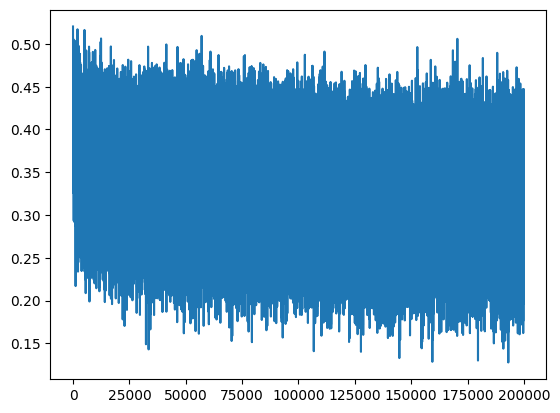

In [81]:
plt.plot(stepi, lossi)

In [22]:
@torch.no_grad()#it disables gradient tracking
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte),
    }[split]
    emb = C[x] #C->looks like (vocab x emblen), x->looks like (examples x block)
    #so emb looks like (examples x block x emblen)
    embcat = emb.view(emb.shape[0],-1) #examples x (block*emblen)
    hpreact = embcat@W1+b1
    #hpreact = bngain * (hpreact-hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True)+bnbias
#     THis need not be used as if we have one example to predict we wudnt be able to find mean/std dev. The other way around is..
    hpreact = bngain * (hpreact-bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h@W2+b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [23]:
split_loss('train')

train 2.066185712814331


In [24]:
split_loss('val')

val 2.1084659099578857


In [85]:
split_loss('test')

test 2.108330249786377


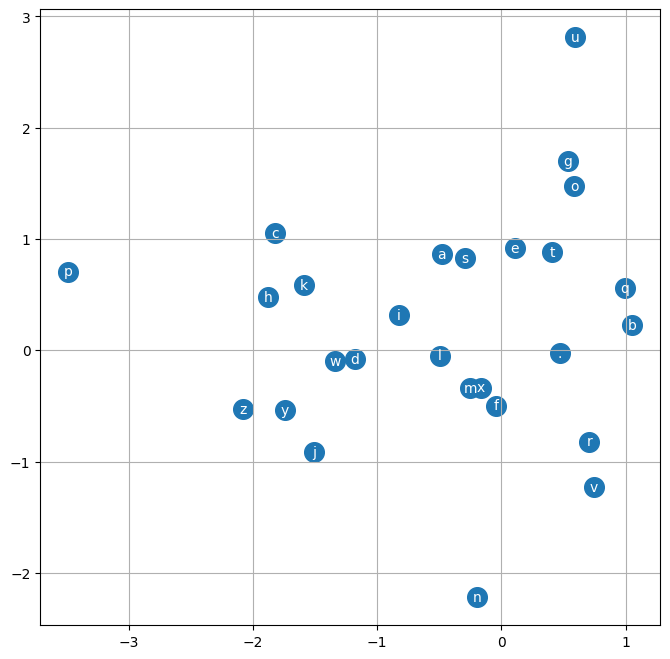

In [58]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [59]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

montaymyah.
seel.
ndhayla.
rensleigh.
raegan.
eled.
elin.
shi.
jen.
eden.
edo.
aarielle.
malka.
cayshab.
ridhiriel.
kinde.
jeniquetzulan.
brence.
ryyah.
fael.
